<a href="https://colab.research.google.com/github/PacktPublishing/Modern-Computer-Vision-with-PyTorch-2E/blob/main/Chapter15/LayoutLMv3_passports.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# %%capture
%pip install transformers[torch] datasets seqeval torch-snippets torchinfo lovely_tensors

In [2]:
from torch_snippets import *
from builtins import print

## Prepare dataset

Next, we prepare the dataset for the model. This can be done very easily using `LayoutLMv3Processor`, which internally wraps a `LayoutLMv3FeatureExtractor` (for the image modality) and a `LayoutLMv3Tokenizer` (for the text modality) into one.

Basically, the processor does the following internally:
* the feature extractor is used to resize + normalize each document image into `pixel_values`
* the tokenizer is used to turn the words, boxes and NER tags into token-level `input_ids`, `attention_mask` and `labels`.

The processor simply returns a dictionary that contains all these keys.

In [3]:
from datasets import load_dataset
dataset = load_dataset('sizhkhy/passports')
examples_train = dataset['train']
examples_eval = dataset['valid']

id2label = {i:v for i, v in set(list(zip(flatten(examples_train['labels']), flatten(examples_train['label_string']))))}
label2id = {v:i for i, v in id2label.items()}

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:80: UserWarning: 
Access to the secret `HF_TOKEN` has not been granted on this notebook.
You will not be requested again.
Please restart the session if you want to be prompted again.
  warnings.warn(


Generating train split:   0%|          | 0/100 [00:00<?, ? examples/s]

Generating valid split:   0%|          | 0/9 [00:00<?, ? examples/s]

In [4]:
examples_train.column_names

['image', 'label_string', 'words', 'labels', 'boxes']

In [5]:
from transformers import AutoProcessor
processor = AutoProcessor.from_pretrained("microsoft/layoutlmv3-base", apply_ocr=False)

def prepare_examples(examples):
  images = examples['image']
  words = examples['words']
  boxes = examples['boxes']
  word_labels = examples['labels']
  encoding = processor(
      images, words, boxes=boxes, word_labels=word_labels,
      truncation=True, padding="max_length")
  return encoding

preprocessor_config.json:   0%|          | 0.00/275 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/1.14k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/856 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

In [6]:
from datasets import Features, Sequence, ClassLabel, Value, Array2D, Array3D

# we need to define custom features for `set_format` (used later on) to work properly
# features = Features({
#     'pixel_values': Array3D(dtype="float32", shape=(3, 224, 224)),
#     'input_ids': Sequence(feature=Value(dtype='int64')),
#     'attention_mask': Sequence(Value(dtype='int64')),
#     'bbox': Array2D(dtype="int64", shape=(512, 4)),
#     'labels': Sequence(feature=Value(dtype='int64')),
# })

train_dataset = examples_train.map(
    prepare_examples,
    batched=True,
    remove_columns=examples_train.column_names,
)

eval_dataset = examples_eval.map(
    prepare_examples,
    batched=True,
    remove_columns=examples_eval.column_names,
)


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Map:   0%|          | 0/9 [00:00<?, ? examples/s]

In [7]:
example = train_dataset[0]
processor.tokenizer.decode(example["input_ids"])

"<s> BELGIE BELGIQUE BELGIEN BELGIUM Type / Type Typ / Type Land van algete / Pays érinttour Ausstellungsland / issuing country Paspoortiummer / N' du passsport Pass Nur Pasaport no EH100396 P 1.Naam / Noms Name / Surname BEL SPECIMEN 2. Vocmaman / Prénoms Vornamen / Given names BARBARA 3. Nationastell / Nationalité Staatsangehörigkeit / Nanonatry BELG 4. Geboortedatum / Date de naissance 6. Geboorteplaats/ Lieu de naissance Geburtsdatum / Date of birth Geburtsort I Place of birth LILLE 06 11 99 B. Geslacht / Seve Gegrzyecht / Sex V-F 7. Datum van afgifte / Dabe de délivrance Ausstellungsdatum / Date of issue 04 06 08 # Geldig tout / Date d'expiration Gullig bis / Dato of expiry 03 06 13 Behörde / Authority UTOPIA to: Handtekening van de houder Signature du titulaire Unterschrift des Passinhabers Holder's signattire perimen P<BELSPECIMEN << BARBARA <<<<<<<<<<<<<<<<<<<<<< EH100396<4BEL9911064F1306031 <<<<<<<<<<<<<< 00</s><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><

Next, we set the format to PyTorch.

In [8]:
train_dataset.set_format("torch")

Let's verify that everything was created properly:

In [9]:
import torch

example = train_dataset[0]
for k,v in example.items():
    print(k,v)

labels tensor[512] i64 4Kb x∈[-100, 14] μ=-70.207 σ=47.451
input_ids tensor[512] i64 4Kb x∈[0, 48629] μ=6.354e+03 σ=1.250e+04
attention_mask tensor[512] i64 4Kb x∈[0, 1] μ=0.646 σ=0.479
bbox tensor[512, 4] i64 n=2048 (16Kb) x∈[0, 939] μ=309.895 σ=289.986
pixel_values tensor[3, 224, 224] n=150528 (0.6Mb) x∈[-0.812, 0.906] μ=0.419 σ=0.298


In [10]:
for id, label in zip(train_dataset[0]["input_ids"], train_dataset[0]["labels"]):
  print(processor.tokenizer.decode([id]), label.item())

<s> -100
 BEL 5
G -100
IE -100
 BEL 5
GI -100
Q -100
UE -100
 BEL 5
GI -100
EN -100
 BEL 5
GI -100
UM -100
 Type 5
 / 5
 Type 5
 Typ 5
 / 5
 Type 5
 Land 5
 van 5
 al 5
get -100
e -100
 / 5
 P 5
ays -100
 é 5
rint -100
t -100
our -100
 Aus 5
st -100
ell -100
ung -100
s -100
land -100
 / 5
 issuing 5
 country 5
 P 5
asp -100
o -100
ortium -100
mer -100
 / 5
 N 5
' -100
 du 5
 pass 5
s -100
port -100
 Pass 5
 Nur 5
 Pas 5
ap -100
ort -100
 no 5
 E 11
H -100
100 -100
396 -100
 P 5
 1 5
. -100
Na -100
am -100
 / 5
 N 5
oms -100
 Name 5
 / 5
 S 5
urn -100
ame -100
 BEL 5
 SPEC 2
IM -100
EN -100
 2 5
. -100
 Voc 5
m -100
aman -100
 / 5
 Pr 5
én -100
oms -100
 V 5
orn -100
amen -100
 / 5
 Given 5
 names 5
 BAR 13
B -100
ARA -100
 3 5
. -100
 Nation 5
ast -100
ell -100
 / 5
 National 5
ité -100
 Sta 5
ats -100
ange -100
h -100
ö -100
rig -100
ke -100
it -100
 / 5
 Nan 5
on -100
at -100
ry -100
 BEL 5
G -100
 4 5
. -100
 G 5
eb -100
o -100
orted -100
atum -100
 / 5
 Date 5
 de 5
 na 5
issance -

## Define metrics

Next, we define a `compute_metrics` function, which is used by the Trainer to ... compute metrics.

This function should take a named tuple as input, and return a dictionary as output as stated in the [docs](https://huggingface.co/docs/transformers/main_classes/trainer).

In [11]:
from datasets import load_metric
metric = load_metric("seqeval")

<ipython-input-11-b45dd5e34816>:2: FutureWarning: load_metric is deprecated and will be removed in the next major version of datasets. Use 'evaluate.load' instead, from the new library 🤗 Evaluate: https://huggingface.co/docs/evaluate
  metric = load_metric("seqeval")
/usr/local/lib/python3.10/dist-packages/datasets/load.py:756: FutureWarning: The repository for seqeval contains custom code which must be executed to correctly load the metric. You can inspect the repository content at https://raw.githubusercontent.com/huggingface/datasets/2.18.0/metrics/seqeval/seqeval.py
You can avoid this message in future by passing the argument `trust_remote_code=True`.
Passing `trust_remote_code=True` will be mandatory to load this metric from the next major release of `datasets`.
  warnings.warn(


In [12]:
import numpy as np

return_entity_level_metrics = False

def compute_metrics(p):
    predictions, labels = p
    predictions = np.argmax(predictions, axis=2)

    # Remove ignored index (special tokens)
    true_predictions = [
        [id2label[p] for (p, l) in zip(prediction, label) if l != -100]
        for prediction, label in zip(predictions, labels)
    ]
    true_labels = [
        [id2label[l] for (p, l) in zip(prediction, label) if l != -100]
        for prediction, label in zip(predictions, labels)
    ]

    results = metric.compute(predictions=true_predictions, references=true_labels)
    if return_entity_level_metrics:
        # Unpack nested dictionaries
        final_results = {}
        for key, value in results.items():
            if isinstance(value, dict):
                for n, v in value.items():
                    final_results[f"{key}_{n}"] = v
            else:
                final_results[key] = value
        return final_results
    else:
        return {
            "precision": results["overall_precision"],
            "recall": results["overall_recall"],
            "f1": results["overall_f1"],
            "accuracy": results["overall_accuracy"],
        }

## Define the model

Next we define the model: this is a Transformer encoder with pre-trained weights, and a randomly initialized head on top for token classification.

In [13]:
from transformers import LayoutLMv3ForTokenClassification

model = LayoutLMv3ForTokenClassification.from_pretrained(
    "microsoft/layoutlmv3-base",
    id2label=id2label,
    label2id=label2id
)

pytorch_model.bin:   0%|          | 0.00/501M [00:00<?, ?B/s]

Some weights of LayoutLMv3ForTokenClassification were not initialized from the model checkpoint at microsoft/layoutlmv3-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


## Define TrainingArguments + Trainer

Next we define the `TrainingArguments`, which define all hyperparameters related to training. Note that there is a huge amount of parameters to tweak, check the [docs](https://huggingface.co/docs/transformers/main_classes/trainer#transformers.TrainingArguments) for more info.

In [19]:
from transformers import TrainingArguments, Trainer

training_args = TrainingArguments(output_dir="test",
                                  max_steps=1000,
                                  per_device_train_batch_size=2,
                                  per_device_eval_batch_size=2,
                                  learning_rate=1e-5,
                                  evaluation_strategy="steps",
                                  eval_steps=50,
                                  load_best_model_at_end=True,
                                  metric_for_best_model="f1")

We can now instantiate a Trainer, with the model and args defined above. We also provide our datasets, as well as a "default data collator" - which will batch the examples using `torch.stack`. We also provide our `compute_metrics` function defined above.

In [20]:
from transformers.data.data_collator import default_data_collator

# Initialize our Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=eval_dataset,
    tokenizer=processor,
    data_collator=default_data_collator,
    compute_metrics=compute_metrics,
)

## Train the model

Let's train!

In [21]:
trainer.train()

Step,Training Loss,Validation Loss,Precision,Recall,F1,Accuracy
50,No log,0.368948,0.200000,0.126984,0.155340,0.892435
100,No log,0.269920,0.400000,0.380952,0.390244,0.944444
150,No log,0.199343,0.492958,0.555556,0.522388,0.951537
200,No log,0.167699,0.646154,0.666667,0.656250,0.965721
250,No log,0.151117,0.730159,0.730159,0.730159,0.972813
300,No log,0.120955,0.777778,0.777778,0.777778,0.979905
350,No log,0.100598,0.784615,0.809524,0.796875,0.984634
400,No log,0.115652,0.793651,0.793651,0.793651,0.978723
450,No log,0.089926,0.750000,0.809524,0.778626,0.981087
500,0.151300,0.078146,0.812500,0.825397,0.818898,0.986998


/usr/local/lib/python3.10/dist-packages/transformers/modeling_utils.py:962: FutureWarning: The `device` argument is deprecated and will be removed in v5 of Transformers.
  warnings.warn(


TrainOutput(global_step=1000, training_loss=0.08986696720123291, metrics={'train_runtime': 781.4471, 'train_samples_per_second': 2.559, 'train_steps_per_second': 1.28, 'total_flos': 530877081600000.0, 'train_loss': 0.08986696720123291, 'epoch': 20.0})

## Evaluate the model

In [22]:
trainer.evaluate()

/usr/local/lib/python3.10/dist-packages/transformers/modeling_utils.py:962: FutureWarning: The `device` argument is deprecated and will be removed in v5 of Transformers.
  warnings.warn(


{'eval_loss': 0.05550934374332428,
 'eval_precision': 0.8709677419354839,
 'eval_recall': 0.8571428571428571,
 'eval_f1': 0.864,
 'eval_accuracy': 0.9893617021276596,
 'eval_runtime': 1.5431,
 'eval_samples_per_second': 5.832,
 'eval_steps_per_second': 3.24,
 'epoch': 20.0}

## Inference

You can load the model for inference as follows:

In [23]:
# # In case you want to load the saved checkpoint - 
# from transformers import AutoModelForTokenClassification
# model = AutoModelForTokenClassification.from_pretrained("/content/test/checkpoint-1000").cuda()

Let's take an example of the training dataset to show inference.

In [24]:
example = examples_eval[0]
print(example.keys())

dict_keys(['image', 'label_string', 'words', 'labels', 'boxes'])


In [25]:
example

{'image': <PIL.PngImagePlugin.PngImageFile image mode=RGB size=600x350>,
 'label_string': ['O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'B-passport_number',
  'O',
  'O',
  'B-surname',
  'I-surname',
  'O',
  'B-name',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'B-date_of_birth',
  'I-date_of_birth',
  'I-date_of_birth',
  'O',
  'O',
  'O',
  'O',
  'B-sex',
  'B-date_of_issue',
  'I-date_of_issue',
  'I-date_of_issue',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'B-date_of_expiry',
  'I-date_of_expiry',
  'I-date_of_expiry',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O']

We first prepare it for the model using the processor.

In [26]:
image = example["image"]
words = example["words"]
boxes = example["boxes"]
word_labels = example["labels"]

encoding = processor(image, words, boxes=boxes, word_labels=word_labels, return_tensors="pt").cuda()
for k,v in encoding.items():
  print(k,v.shape)

input_ids torch.Size([1, 304])
attention_mask torch.Size([1, 304])
bbox torch.Size([1, 304, 4])
labels torch.Size([1, 304])
pixel_values torch.Size([1, 3, 224, 224])


Next, we do a forward pass. We use torch.no_grad() as we don't require gradient computation.

In [27]:
with torch.no_grad():
  outputs = model(**encoding)

The model outputs logits of shape (batch_size, seq_len, num_labels).

In [28]:
logits = outputs.logits
logits.shape

torch.Size([1, 304, 15])

In [29]:
import torch.nn.functional as F
confs = F.softmax(logits, dim=-1).squeeze().tolist()

We take the highest score for each token, using argmax. This serves as the predicted label for each token.

In [30]:
predictions = logits.argmax(-1).squeeze().tolist()
confs = [li[p] for (li,p) in zip(confs, predictions)]
print(predictions, confs)

[5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 11, 11, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 2, 2, 4, 9, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 13, 13, 9, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 0, 3, 3, 5, 5, 5, 5, 5, 5, 5, 5, 5, 12, 6, 7, 7, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 14, 8, 8, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5] [0.1751505732536316, 0.9992192983627319, 0.9992039799690247, 0.9992013573646545, 

Let's compare this to the ground truth: note that many labels are -100, as we're only labeling the first subword token of each word.

NOTE: at "true inference" time, you don't have access to labels, see the latest section of this notebook how you can use `offset_mapping` in that case.

In [31]:
labels = encoding.labels.squeeze().tolist()
print(labels)

[-100, 5, -100, -100, 5, 5, -100, -100, 5, -100, -100, 5, -100, -100, -100, 5, -100, 5, -100, -100, -100, -100, -100, -100, 5, -100, 5, 5, -100, -100, -100, 5, 5, -100, -100, -100, -100, -100, 5, 5, -100, 5, -100, -100, 5, -100, -100, -100, 5, -100, -100, -100, -100, -100, 5, 5, -100, -100, -100, -100, -100, 5, -100, -100, -100, -100, -100, -100, 5, 5, 11, -100, 5, -100, 5, -100, -100, -100, -100, -100, -100, -100, -100, 2, -100, 4, -100, 5, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, 13, -100, -100, 5, -100, -100, -100, -100, -100, -100, -100, 5, -100, -100, -100, -100, -100, -100, 5, -100, -100, -100, 5, -100, -100, -100, 5, -100, -100, 5, -100, -100, 5, -100, -100, 5, 5, 5, 5, 5, 5, -100, -100, 5, -100, 5, 5, -100, 5, -100, -100, 5, -100, 5, -100, -100, -100, -100, -100, -100, -100, 0, 3, 3, 5, -100, 5, -100, 5, -100, 5, -100, -100, 12, 6, 7, 7, 5, -100, 5, 5, -100, -100, 5, -100, 5, 5, -100, 5, -100, 5, 5, -100, 5, -100, -100, 5, 5, -100, -100, 5, 5, -100, 5, 

So let's only compare predictions and labels at positions where the label isn't -100. We also want to have the bounding boxes of these (unnormalized):

In [32]:
def unnormalize_box(bbox, width, height):
      return [
          width * (bbox[0] / 1000),
          height * (bbox[1] / 1000),
          width * (bbox[2] / 1000),
          height * (bbox[3] / 1000),
      ]
token_boxes = encoding.bbox.squeeze().tolist()
width, height = image.size

true_predictions = [model.config.id2label[pred] for pred, label in zip(predictions, labels) if label != - 100]
true_labels = [model.config.id2label[label] for prediction, label in zip(predictions, labels) if label != -100]
true_boxes = [unnormalize_box(box, width, height) for box, label in zip(token_boxes, labels) if label != -100]

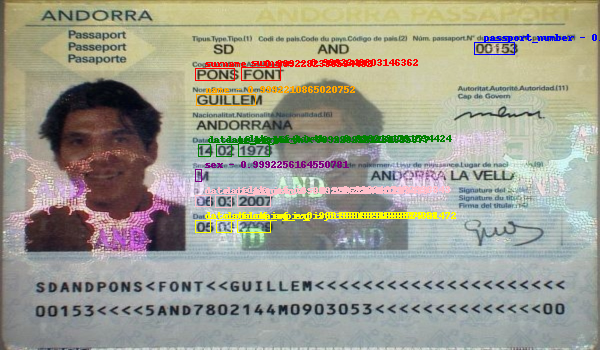

In [33]:
from PIL import ImageDraw, ImageFont

draw = ImageDraw.Draw(image)

font = ImageFont.load_default()

def iob_to_label(label):
    label = label[2:]
    if not label:
      return 'other'
    return label

label2color = {'passport_number':'blue', 'date_of_birth':'green', 'name':'orange', 'fathers_name':'violet', 'surname': 'red','other':'black', 'sex':'purple', 'date_of_expiry': 'yellow', 'date_of_issue': 'pink'}

for prediction, box, conf in zip(true_predictions, true_boxes, confs):
    predicted_label = iob_to_label(prediction).lower()
    if predicted_label != 'other':
      draw.rectangle(box, outline=label2color[predicted_label])
      draw.text((box[0] + 10, box[1] - 10), text=f'{predicted_label} - {conf}', fill=label2color[predicted_label], font=font)

image

Compare this to the ground truth:

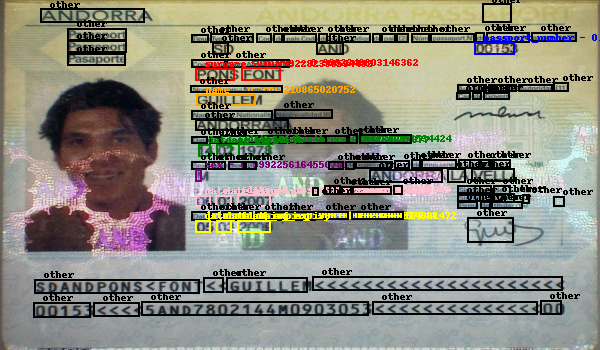

In [35]:
image = example["image"]
image = image.convert("RGB")

draw = ImageDraw.Draw(image)

for word, box, label in zip(example['words'], example['boxes'], example['labels']):
  actual_label = iob_to_label(id2label[label]).lower()
  box = unnormalize_box(box, width, height)
  draw.rectangle(box, outline=label2color[actual_label], width=2)
  draw.text((box[0] + 10, box[1] - 10), actual_label, fill=label2color[actual_label], font=font)

image